In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% pip install pdbpp

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for pdbpp: filename=pdbpp-0.10.2-py2.py3-none-any.whl size=23749 sha256=7c0030f8852388ab5c471599fee06c24568d7b69994a6906d6a9ce8541bd4ee9
  Stored in directory: /root/.cache/pip/wheels/c3/fb/22/af5cd9592306ae3dfedbb58940f43f42134713bf594559065f
  Created wheel for wmctrl: filename=wmctrl-0.3-cp36-none-any.whl size=2041 sha256=c03cddfacf2dc0b19060ac3ad984af705fc44ea084a0b24e1e38ce5e49b6d5bc
  Stored in directory: /root/.cache/pip/wheels/01/25/60/7cfd4de7944c37564b983376e1ba70fc3ef7df2367a1c41642
  Created wheel for pyrepl: filename=pyrepl-0.9.0-cp36-none-any.whl size=59892 sha256=72a49959a31f011f7e515cd5169232834ae652ea5775f79199f27acbde6b5ebf
  Stored in directory: /root/.cache/pip/wheels/c6/a8/9c/a20d43bcd31f378f94caacf85c006f015c966d6633d69fbfdc
Successfully built pdbpp wmctrl pyrepl


In [1]:
% pip install wandb -q

     |████████████████████████████████| 1.8MB 8.9MB/s 
     |████████████████████████████████| 133kB 31.6MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 163kB 23.8MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Turning off tensorflow warning message (not recommended)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as kb
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import Callback
import random
import pdb
import wandb
from os.path import join, isfile
from os import listdir

In [4]:
print(tf.__version__)

1.15.2


In [5]:
wandb.login()

wandb: Currently logged in as: awesomericky (use `wandb login --relogin` to force relogin)


True

In [7]:
device_name = tf.test.gpu_device_name()
print('Found GPU at {}'.format(device_name))

Found GPU at /device:GPU:0


In [6]:
"""
utils.py
"""

def read_script_files(script_dir_path):
    script_files = [f for f in listdir(script_dir_path) if isfile(join(script_dir_path, f))]
    script_files.sort()
    return script_files

def data_shuffle(relative_data_directory_path):
    data_files = read_script_files(relative_data_directory_path)
    random.shuffle(data_files)
    return data_files

In [7]:
"""
processed_data_loader.py
"""

def load_single_npz_data(relative_data_directory_path, file_name):
    file_path = join(relative_data_directory_path, file_name)
    data = np.load(file=file_path)
    return data

In [51]:
"""
TCN_and_decoder.py
"""

class ResidualBlock(tf.keras.Model):
    def __init__(self, dilation_rate, num_filters, kernel_size, padding, 
                        dropout_rate, activation, seed, training_state):
        super(ResidualBlock, self).__init__()
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=seed)
        layers = tf.keras.layers
        assert padding in ['causal', 'same']

        self.training_state = training_state

        # Block1
        self.conv1 = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, data_format='channels_last',
                                    dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
        self.batch1 = layers.BatchNormalization(axis=1, trainable=True)
        if activation == 'leaky-relu':
            self.ac1 = layers.LeakyReLU(alpha=0.3)
        else:
            self.ac1 = layers.Activation(activation)
        self.drop1 = layers.Dropout(rate=dropout_rate)

        # Block2
        self.conv2 = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, data_format='channels_last',
                                    dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
        self.batch2 = layers.BatchNormalization(axis=1, trainable=True)
        if activation == 'leaky-relu':
            self.ac2 = layers.LeakyReLU(alpha=0.3)
        else:
            self.ac2 = layers.Activation(activation)
        self.drop2 = layers.Dropout(rate=dropout_rate)

        self.downsample = layers.Conv1D(filters=num_filters, kernel_size=1,
                                        padding='same', kernel_initializer=init)
        if activation == 'leaky-relu':
            self.ac3 = layers.LeakyReLU(alpha=0.3)
        else:
            self.ac3 = layers.Activation(activation)
    
    def call(self, x):
        # Block1
        prev_x = x
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ac1(x)
        x = self.drop1(x) if self.training_state else x

        # Block2
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.ac2(x)
        x = self.drop2(x) if self.training_state else x

        # Match dimention
        if prev_x.shape[-1] != x.shape[-1]:
            prev_x = self.downsample(prev_x)
        assert prev_x.shape[1:] == x.shape[1:]

        # skip connection
        return self.ac3(prev_x + x)

class TemporalBlock(tf.keras.Model):
    def __init__(self, num_channels, kernel_size, dropout_rate, activation, seed, training_state):
        # num_channels is a list contains hidden channel numbers of Conv1D
        # len(num_channels) is number of convolutional layers in one Temporal Block
        super(TemporalBlock, self).__init__()
        assert isinstance(num_channels, list)

        self.num_levels = len(num_channels)
        self.resi_blocks = [0]*self.num_levels
        for i in range(self.num_levels):
            dilation_rate = 2**i
            self.resi_blocks[i] = ResidualBlock(dilation_rate, num_channels[i], kernel_size, padding='causal',
                            dropout_rate=dropout_rate, activation=activation, seed=seed, training_state=training_state)
    
    def call(self, x):
        for i in range(self.num_levels):
            x = self.resi_blocks[i](x)
        return x

class TempConvnet(tf.keras.Model):
    def __init__(self, num_stacks, num_channels, kernel_size, dropout_rate, activation, return_type, seed, training_state):
        # num_stacks number of Temporal Blocks in Temporal convolutional network
        super(TempConvnet, self).__init__()
        assert isinstance(num_stacks, int)
        assert isinstance(num_channels, list)
        assert isinstance(activation, str)
        assert return_type in ['whole', 'end']

        self.num_stacks = num_stacks
        self.temp_blocks = [0]*self.num_stacks
        self.return_type = return_type
        for i in range(num_stacks):
            self.temp_blocks[i] = TemporalBlock(num_channels, kernel_size=kernel_size, dropout_rate=dropout_rate, activation=activation, seed=seed, training_state=training_state)
    
    def call(self, x):
        for i in range(self.num_stacks):
            x = self.temp_blocks[i](x)
        
        if self.return_type == 'whole':
            return x
        elif self.return_type == 'end':
            return x[:, -1, :]

class TempConvnet_Decoder(tf.keras.Model):
    def __init__(self, decoder_type, num_channels, kernel_size, padding, dropout_rate, activation, seed, training_state):
        super(TempConvnet_Decoder, self).__init__()
        assert isinstance(num_channels, int)
        assert isinstance(kernel_size, list)
        assert isinstance(activation, str)
        assert padding in ['causal', 'same']
        assert decoder_type in ['linguistic', 'acoustic']

        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=seed)
        layers = tf.keras.layers

        self.training_state = training_state

        # Block1
        self.upsample_block1 = layers.UpSampling1D(size=3)
        self.conv_block1 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block1 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block1 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block1 = layers.Dropout(rate=dropout_rate)

        # Extra block0
        self.conv_block_e0 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e0 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e0 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e0 = layers.Dropout(rate=dropout_rate)

        # Block2
        self.upsample_block2 = layers.UpSampling1D(size=3)
        self.conv_block2 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block2 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block2 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block2 = layers.Dropout(rate=dropout_rate)

        # Extra block1
        self.conv_block_e1 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e1 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e1 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e1 = layers.Dropout(rate=dropout_rate)

        # Block3
        self.upsample_block3 = layers.UpSampling1D(size=2)
        self.conv_block3 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block3 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block3 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block3 = layers.Dropout(rate=dropout_rate)

        # Extra block2
        self.conv_block_e2 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e2 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e2 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e2 = layers.Dropout(rate=dropout_rate)

        # Block4
        self.conv_block4 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding='valid', kernel_initializer=init)
        self.batchnorm_block4 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block4 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block4 = layers.Dropout(rate=dropout_rate)

        # Extra block3
        self.conv_block_e3 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e3 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e3 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e3 = layers.Dropout(rate=dropout_rate)

        # Block5
        self.upsample_block5 = layers.UpSampling1D(size=2)
        self.conv_block5 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block5 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block5 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block5 = layers.Dropout(rate=dropout_rate)

        # Extra block4
        self.conv_block_e4 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e4 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e4 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e4 = layers.Dropout(rate=dropout_rate)

        # Block6
        self.upsample_block6 = layers.UpSampling1D(size=3)
        self.conv_block6 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block6 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block6 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block6 = layers.Dropout(rate=dropout_rate)

        # Extra block5
        self.conv_block_e5 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e5 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e5 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e5 = layers.Dropout(rate=dropout_rate)

        # Block7
        self.conv_block7 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding='valid', kernel_initializer=init)
        self.batchnorm_block7 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block7 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block7 = layers.Dropout(rate=dropout_rate)

        # Extra block6
        self.conv_block_e6 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e6 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e6 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e6 = layers.Dropout(rate=dropout_rate)

        # Block8
        self.upsample_block8 = layers.UpSampling1D(size=3)
        self.conv_block8 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block8 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block8 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block8 = layers.Dropout(rate=dropout_rate)

        # Extra block7
        self.conv_block_e7 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[1], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e7 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e7 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e7 = layers.Dropout(rate=dropout_rate)

        # Extra block8
        self.conv_block_e8 = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[1], data_format='channels_last',
                                            padding=padding, kernel_initializer=init)
        self.batchnorm_block_e8 = layers.BatchNormalization(axis=-1, trainable=True)
        self.ac_block_e8 = layers.Activation(activation) if activation != 'leaky-relu' else layers.LeakyReLU(alpha=0.2)
        self.drop_block_e8 = layers.Dropout(rate=dropout_rate)

        # Block9 (final block)
        self.final_conv_block = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[1], data_format='channels_last',
                                                    padding=padding, kernel_initializer=init)
        self.final_ac_block = layers.Softmax(axis=-1)
        self.final_reshape_block = layers.Permute((2, 1))
    
    def call(self, x):
        x = self.upsample_block1(x)
        x = self.conv_block1(x)
        x = self.batchnorm_block1(x)
        x = self.ac_block1(x)
        x = self.drop_block1(x) if self.training_state else x
        x = self.conv_block_e0(x)
        x = self.batchnorm_block_e0(x)
        x = self.ac_block_e0(x)
        x = self.drop_block_e0(x) if self.training_state else x
        x = self.upsample_block2(x)
        x = self.conv_block2(x)
        x = self.batchnorm_block2(x)
        x = self.ac_block2(x)
        x = self.drop_block2(x) if self.training_state else x
        x = self.conv_block_e1(x)
        x = self.batchnorm_block_e1(x)
        x = self.ac_block_e1(x)
        x = self.drop_block_e1(x) if self.training_state else x
        x = self.upsample_block3(x)
        x = self.conv_block3(x)
        x = self.batchnorm_block3(x)
        x = self.ac_block3(x)
        x = self.drop_block3(x) if self.training_state else x
        x = self.conv_block_e2(x)
        x = self.batchnorm_block_e2(x)
        x = self.ac_block_e2(x)
        x = self.drop_block_e2(x) if self.training_state else x
        x = self.conv_block4(x)
        x = self.batchnorm_block4(x)
        x = self.ac_block4(x)
        x = self.drop_block4(x) if self.training_state else x
        x = self.conv_block_e3(x)
        x = self.batchnorm_block_e3(x)
        x = self.ac_block_e3(x)
        x = self.drop_block_e3(x) if self.training_state else x
        x = self.upsample_block5(x)
        x = self.conv_block5(x)
        x = self.batchnorm_block5(x)
        x = self.ac_block5(x)
        x = self.drop_block5(x) if self.training_state else x
        x = self.conv_block_e4(x)
        x = self.batchnorm_block_e4(x)
        x = self.ac_block_e4(x)
        x = self.drop_block_e4(x) if self.training_state else x
        x = self.upsample_block6(x)
        x = self.conv_block6(x)
        x = self.batchnorm_block6(x)
        x = self.ac_block6(x)
        x = self.drop_block6(x) if self.training_state else x
        x = self.conv_block_e5(x)
        x = self.batchnorm_block_e5(x)
        x = self.ac_block_e5(x)
        x = self.drop_block_e5(x) if self.training_state else x
        x = self.conv_block7(x)
        x = self.batchnorm_block7(x)
        x = self.ac_block7(x)
        x = self.drop_block7(x) if self.training_state else x
        x = self.conv_block_e6(x)
        x = self.batchnorm_block_e6(x)
        x = self.ac_block_e6(x)
        x = self.drop_block_e6(x) if self.training_state else x
        x = self.upsample_block8(x)
        x = self.conv_block8(x)
        x = self.batchnorm_block8(x)
        x = self.ac_block8(x)
        x = self.drop_block8(x) if self.training_state else x
        x = self.conv_block_e7(x)
        x = self.batchnorm_block_e7(x)
        x = self.ac_block_e7(x)
        x = self.drop_block_e7(x) if self.training_state else x
        x = self.conv_block_e8(x)
        x = self.batchnorm_block_e8(x)
        x = self.ac_block_e8(x)
        x = self.drop_block_e8(x) if self.training_state else x
        x = self.final_conv_block(x)
        x = self.final_ac_block(x)
        y = self.final_reshape_block(x)
        return y

In [52]:
"""
sentenceEM.py
"""

class sentenceEM(tf.keras.Model):
    def __init__(self, encoder_args, linguistic_decoder_args, input_shapes, seed, training_state):
        """
        1) encoder_args: 
        num_stacks, num_channels, kernel_size, dropout_rate, return_type, seed
        2) linguistic_decoder_args:
        decoder_type, num_channels, kernel_size, padding, dropout_rate, seed, training_state
        """
        super(sentenceEM, self).__init__()
        self.input_shapes = input_shapes
        self.input_reshape_block = layers.Permute((2, 1))
        self.encoder = TempConvnet(num_stacks=encoder_args['num_stacks'], num_channels=encoder_args['num_channels'],
                                   kernel_size=encoder_args['kernel_size'], dropout_rate=encoder_args['dropout_rate'], activation=encoder_args['activation'],
                                   return_type=encoder_args['return_type'], seed=seed, training_state=training_state)
        self.linguistic_decoder = TempConvnet_Decoder(decoder_type=linguistic_decoder_args['decoder_type'], num_channels=linguistic_decoder_args['num_channels'], 
                                                      kernel_size=linguistic_decoder_args['kernel_size'], padding=linguistic_decoder_args['padding'],
                                                      dropout_rate=linguistic_decoder_args['dropout_rate'], activation=linguistic_decoder_args['activation'],
                                                      seed=seed, training_state=training_state)
    
    def call(self, x):
        embedded_outputs = self.input_reshape_block(x)
        embedded_outputs = self.encoder(embedded_outputs)
        embedded_outputs = kb.expand_dims(embedded_outputs, axis=1)
        linguistic_outputs = self.linguistic_decoder(embedded_outputs)
        return linguistic_outputs
    
    def encoder_call(self, x):
        embedded_outputs = self.input_reshape_block(x)
        embedded_outputs = self.encoder(embedded_outputs)
        return embedded_outputs
    
    def decoder_call(self, x):
        embedded_outputs = kb.expand_dims(x, axis=1)
        linguistic_outputs = self.linguistic_decoder(embedded_outputs)
        return linguistic_outputs
    
    def build_seperate_graph(self):
        # Encoder graph
        x = tf.keras.Input(batch_shape=self.input_shapes)
        embedded_outputs = self.encoder_call(x)
        self.embedded_outputs_shape = embedded_outputs.shape
        self.encoder_model = tf.keras.Model(inputs=x, outputs=embedded_outputs)

        # Decoder graph
        embeddings = tf.keras.Input(batch_shape=self.embedded_outputs_shape)
        linguistic_outputs = self.decoder_call(embeddings)
        self.decoder_model = tf.keras.Model(inputs=embeddings, outputs=[linguistic_outputs])
    
    def build_total_graph(self):
        x = tf.keras.Input(batch_input_shape=self.input_shapes)
        y = self.encoder_model(x)
        l_y = self.decoder_model(y)
        self.model = tf.keras.Model(inputs=x, outputs=[l_y])

    def model_visualize(self):
        self.model.summary()
        # plot_model(self.model, to_file='/home/awesomericky/Lab_intern/Prof_Oh/Code/Speech2Pickup/image/sentenceEM.png')
    
    def encoder_model_compile(self, lr):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.encoder_model.compile(optimizer=optimizer)

    def model_compile(self, lr):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        metric = self.custom_metric()
        self.model.compile(optimizer=optimizer, loss=[self.linguistic_loss_function], metrics=[metric])

    def model_train(self, X_train, Y_linguistic_train, batch_size, epochs, total_model_file_path, encoder_model_file_path):
        custom_callback = CustomCallback(total_model_file_path, encoder_model_file_path, self.model, self.encoder_model)
        self.model.fit(x=X_train, y=[Y_linguistic_train], batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[custom_callback])

    def custom_metric(self):
        def categorical_accuracy(y_true, y_pred):
            ind_actual = tf.math.argmax(y_true, axis=1)
            ind_predict = tf.math.argmax(y_pred, axis=1)
            batch_size = ind_predict.shape[0]
            time_size = ind_predict.shape[1]
            count = tf.reduce_sum(tf.cast(tf.math.equal(ind_actual, ind_predict), tf.int32), axis=1)
            accuracy = tf.math.reduce_mean(tf.math.divide(count, time_size))
            return accuracy
        categorical_accuracy.__name__ = 'categorical_accuracy'
        return categorical_accuracy

    def linguistic_loss_function(self, y_actual, y_predicted):
        epsil = 1e-5
        y_predicted_correct = -kb.log(y_predicted + epsil)
        # y_predicted_incorrect = -kb.log(1 - y_predicted + epsil)
        # y_actual_op = tf.math.subtract(tf.ones_like(y_actual), y_actual)

        correct_loss = layers.multiply([y_actual, y_predicted_correct])
        # incorrect_loss = layers.multiply([y_actual_op, y_predicted_incorrect])
        # loss = tf.math.add(correct_loss, incorrect_loss)
        loss = kb.sum(correct_loss, axis=1)
        loss = kb.mean(loss, keepdims=False)
        return loss

class CustomCallback(Callback):
    def __init__(self, total_model_file_path, encoder_model_file_path, total_model, encoder_model):
        self.total_model_file_path = total_model_file_path
        self.encoder_model_file_path = encoder_model_file_path
        self.total_model = total_model
        self.encoder_model = encoder_model
        self.monitor = 'categorical_accuracy'
        self.monitor_op = np.greater
        self.best = 0
        self.temp_loss = []
        self.temp_linguistic_accuracy = []
    
    def on_batch_end(self, batch, logs=None):
        self.temp_loss.append(logs.get('loss'))
        self.temp_linguistic_accuracy.append(logs.get('categorical_accuracy'))

    def on_epoch_end(self, epoch, logs=None):
        self.temp_loss.append(logs.get('loss'))
        self.temp_linguistic_accuracy.append(logs.get('categorical_accuracy'))

        # Logging data
        for iii in range(len(self.temp_loss)):
            wandb.log({'temp_loss': self.temp_loss[iii]})
            wandb.log({'temp_linguistic_accuracy': self.temp_linguistic_accuracy[iii]})
        self.temp_loss = []
        self.temp_linguistic_accuracy = []
        
        # Save model
        current = logs.get(self.monitor)
        if self.monitor_op(current, self.best):
            self.best = current
            self.total_model.save_weights(filepath=self.total_model_file_path, overwrite=True)
            self.encoder_model.save_weights(filepath=self.encoder_model_file_path, overwrite=True)

In [71]:
# Configure model

train_model_number = 12
batch_size = 36; seed = 1; lr = 0.0005; epochs = 50
n_mels = 40
time_steps = 303
word_dic_size = 43
dropout_rate = 0.2
training_state = True
input_shapes = (None, n_mels, time_steps)
encoder_args = {'num_stacks': 3, 'num_channels':[n_mels for i in range(6)], 'kernel_size':3,
                'dropout_rate': dropout_rate, 'activation': 'leaky-relu', 'return_type': 'end'}
linguistic_decoder_args = {'decoder_type': 'linguistic', 'num_channels': word_dic_size, 'kernel_size': [2, 2],
                           'padding': 'same', 'dropout_rate': dropout_rate, 'activation': 'leaky-relu'}

with tf.device('/device:GPU:0'):
    sen_em_model = sentenceEM(encoder_args=encoder_args, linguistic_decoder_args=linguistic_decoder_args,
                              input_shapes=input_shapes, seed=seed, training_state=training_state)
    sen_em_model.build_seperate_graph()
    sen_em_model.build_total_graph()
    sen_em_model.model_compile(lr=lr)
sen_em_model.model_visualize()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40, 303)]         0         
_________________________________________________________________
model (Model)                (None, 40)                217872    
_________________________________________________________________
model_1 (Model)              (None, 43, 303)           70004     
Total params: 287,876
Trainable params: 264,598
Non-trainable params: 23,278
_________________________________________________________________


In [ ]:
# Train model

wandb_config = {'batch_size':batch_size,
                'learning_rate': lr,
                'channel_type': 'single',
                'n_mels': n_mels,
                'seed': seed,
                'date': '2020-12-06',
                'train_model_number': train_model_number,
                'Encoder activation': encoder_args['activation'],
                'Linguistic decoder activation': linguistic_decoder_args['activation'],
                'Decoder kernel':  linguistic_decoder_args['kernel_size'],
                'memo': 'init std=0.1, Dropout_rate: 0.2',
                'model type': 'modified model(only linguistic)'}
wandb_run = wandb.init(project='Speech2Pickup', name='sentenceEM', config=wandb_config)
total_model_file_path = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/total_model/sentenceEM_total_model'
encoder_model_file_path = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/encoder_model/sentenceEM_encoder_model'
model_configuration_file = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/model_config.txt'
relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/data_v2.2_single_channel'

# Write model configuration in .txt file
with open(model_configuration_file, 'w') as f:
    f.write(str(wandb_config))

# # Load data
# print('Loading data...')
# data_file = listdir(relative_data_directory_path)[0]
# data = load_single_npz_data(relative_data_directory_path=relative_data_directory_path, file_name=data_file)
# acoustic_data = data['acoustic']
# linguistic_data = data['linguistic']

# Train model and save
print('Start training')
try:
    # Train
    with tf.device('/device:GPU:0'):
        sen_em_model.model_train(X_train=acoustic_data, Y_linguistic_train=linguistic_data, batch_size=batch_size, epochs=epochs,
                                 total_model_file_path=total_model_file_path, encoder_model_file_path=encoder_model_file_path)
except KeyboardInterrupt:
    pass

Loading data...


In [70]:
# Erase model from memory
# Finish wandb process

tf.keras.backend.clear_session()
del sen_em_model
wandb_run.finish()

temp_loss,0.31027
_step,52071
_runtime,2016
_timestamp,1607196177
temp_linguistic_accuracy,0.87837


temp_loss,█▆▅▃▃▄▃▂▂▂▃▃▂▃▂▂▂▃▂▂▂▂▃▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
temp_linguistic_accuracy,▁▃▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████


In [30]:
# Load model (model compiling should be done first)

model_path = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/total_model/sentenceEM_total_model'
sen_em_model.model.load_weights(model_path)

In [15]:
"""
utils.py
"""

def read_script_files(script_dir_path):
    script_files = [f for f in listdir(script_dir_path) if isfile(join(script_dir_path, f))]
    script_files.sort()
    return script_files

def read_script_file_data(script_dir_path, script_file):
    curr_file = open(join(script_dir_path, script_file), 'r')
    curr_file_lines = curr_file.readlines()
    for i in range(len(curr_file_lines)):
        words = curr_file_lines[i].split()[2: ]
        curr_file_lines[i] = ' '.join(words)
    return curr_file_lines

In [16]:
"""
process_data.py
"""

def make_word_dictionary(relative_script_directory_path):
    # Check whole word candidates
    script_files = read_script_files(relative_script_directory_path)
    total_words = set()
    num = 0
    for script_file in script_files:
        num += 1
        print('Processing {}/{}'.format(num, len(script_files)))
        curr_file_lines = read_script_file_data(relative_script_directory_path, script_file)
        for curr_file_line in curr_file_lines:
            total_words.update(set(curr_file_line.split()))
    total_words = list(total_words)
    total_words.append("")  # blank
    total_words.append("OOV")  # Out of vocabulary
    total_words.sort()

    # One-hot encoding
    word_dictionary = dict()
    word_dictionary_size = len(total_words)
    for i in range(word_dictionary_size):
        one_hot = np.zeros(word_dictionary_size)
        one_hot[i] = 1
        word_dictionary[total_words[i]] = one_hot
    # print(word_dictionary)
    return word_dictionary, word_dictionary_size

In [17]:
# Set word dictionary to check output of model later

relative_script_directory_path = './drive/MyDrive/Speech2Pickup/train_script'
word_dic, word_dic_size = make_word_dictionary(relative_script_directory_path)

Processing 1/478
Processing 2/478
Processing 3/478
Processing 4/478
Processing 5/478
Processing 6/478
Processing 7/478
Processing 8/478
Processing 9/478
Processing 10/478
Processing 11/478
Processing 12/478
Processing 13/478
Processing 14/478
Processing 15/478
Processing 16/478
Processing 17/478
Processing 18/478
Processing 19/478
Processing 20/478
Processing 21/478
Processing 22/478
Processing 23/478
Processing 24/478
Processing 25/478
Processing 26/478
Processing 27/478
Processing 28/478
Processing 29/478
Processing 30/478
Processing 31/478
Processing 32/478
Processing 33/478
Processing 34/478
Processing 35/478
Processing 36/478
Processing 37/478
Processing 38/478
Processing 39/478
Processing 40/478
Processing 41/478
Processing 42/478
Processing 43/478
Processing 44/478
Processing 45/478
Processing 46/478
Processing 47/478
Processing 48/478
Processing 49/478
Processing 50/478
Processing 51/478
Processing 52/478
Processing 53/478
Processing 54/478
Processing 55/478
Processing 56/478
P

True: pick up the top block which color is purple 
Predict: pick up the top upper block which color is green yellow 


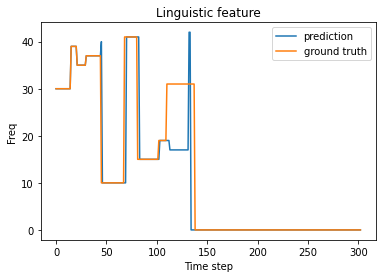

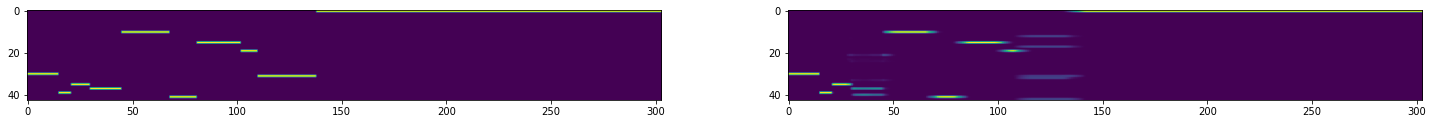

In [69]:
# Check output of loaded model

import matplotlib.pyplot as plt
import librosa.display

relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/data_v2.2_single_channel'
file_name = 'senEM_preprocessed.npz'
n_data = 9
# data = load_single_npz_data(relative_data_directory_path=relative_data_directory_path, file_name=file_name)
acoustic_train_batch = [data['acoustic'][n_data]]
linguistic_train_batch = [data['linguistic'][n_data]]
acoustic_train_batch = np.array(acoustic_train_batch, dtype=np.float32)
linguistic_train_batch = np.array(linguistic_train_batch, dtype=np.float32)

with tf.device('/device:GPU:0'):
    l_out_full = sen_em_model.model(acoustic_train_batch)

l_out_full = np.squeeze(kb.eval(l_out_full))
l_true = np.squeeze(linguistic_train_batch)

l_out = np.argmax(l_out_full, axis=0)
l_true = np.argmax(l_true, axis=0)

true_sentence = []
predicted_sentence = []
word_dic_keys = list(word_dic.keys())
n = 0
for i in l_true:
  if n==0:
    true_sentence.append(word_dic_keys[i])
  elif true_sentence[-1] != word_dic_keys[i]:
    true_sentence.append(word_dic_keys[i])
  n += 1
n = 0
for i in l_out:
  if n==0:
    predicted_sentence.append(word_dic_keys[i])
  elif predicted_sentence[-1] != word_dic_keys[i]:
    predicted_sentence.append(word_dic_keys[i])
  n += 1
true_sentence = ' '.join(true_sentence)
predicted_sentence = ' '.join(predicted_sentence)
print('True: {}'.format(true_sentence))
print('Predict: {}'.format(predicted_sentence))

fig, ax = plt.subplots(1)
ax.plot(l_out, label='prediction')
ax.plot(l_true, label='ground truth')
ax.set_title('Linguistic feature')
ax.set_xlabel('Time step')
ax.set_ylabel('Freq')
plt.legend()
plt.show()

# Draw contour
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
ax[0].imshow(data['linguistic'][n_data])
ax[1].imshow(l_out_full)

In [42]:
print(l_out_full[:, 80])
print(np.argmax(l_out_full[:, 80]))
# l_out_full[np.argmax(l_out_full[:, 80]), 80] = 0
print(np.max(l_out_full[:, 80]))
print(np.argmax(l_out_full[:, 80]))

print(linguistic_train_batch[0, :, 80])

[9.29300040e-02 2.84429989e-04 4.44116478e-04 2.46811984e-03
 6.97561365e-04 4.29398700e-04 1.34461066e-02 2.98137544e-04
 3.78939760e-04 2.23112386e-02 0.00000000e+00 1.10977201e-03
 9.52419266e-03 2.11608242e-02 3.05807404e-03 1.96720790e-02
 8.09166057e-04 1.82525553e-02 9.66150314e-04 9.92825080e-05
 4.53395507e-04 1.66819077e-02 7.45027140e-03 2.95320414e-02
 5.54175256e-03 1.49283453e-03 1.60773110e-03 2.04968471e-02
 3.66136734e-03 5.24275424e-03 4.22216486e-04 2.23344956e-02
 1.29565075e-02 1.13783358e-02 6.44481182e-03 9.03429911e-02
 5.78750565e-04 1.90990400e-02 1.86547812e-03 3.61705548e-04
 2.36015879e-02 1.38539195e-01 1.88974198e-02]
41
0.1385392
41
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [44]:
print(l_out_full[:, 80])
print(np.argmax(l_out_full[:, 80]))
# l_out_full[np.argmax(l_out_full[:, 80]), 80] = 0
print(np.max(l_out_full[:, 80]))
print(np.argmax(l_out_full[:, 80]))

print(linguistic_train_batch[0, :, 80])

[9.29300040e-02 2.84429989e-04 4.44116478e-04 2.46811984e-03
 6.97561365e-04 4.29398700e-04 1.34461066e-02 2.98137544e-04
 3.78939760e-04 2.23112386e-02 3.52676421e-01 1.10977201e-03
 9.52419266e-03 2.11608242e-02 3.05807404e-03 1.96720790e-02
 8.09166057e-04 1.82525553e-02 9.66150314e-04 9.92825080e-05
 4.53395507e-04 1.66819077e-02 7.45027140e-03 2.95320414e-02
 5.54175256e-03 1.49283453e-03 1.60773110e-03 2.04968471e-02
 3.66136734e-03 5.24275424e-03 4.22216486e-04 2.23344956e-02
 1.29565075e-02 1.13783358e-02 6.44481182e-03 9.03429911e-02
 5.78750565e-04 1.90990400e-02 1.86547812e-03 3.61705548e-04
 2.36015879e-02 1.38539195e-01 1.88974198e-02]
10
0.35267642
10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
acoustic_train_batch = [data['acoustic'][40000]]
acoustic_train_batch = np.array(acoustic_train_batch, dtype=np.float32)
with tf.device('/device:GPU:0'):
    l_out_full = sen_em_model.encoder_model(acoustic_train_batch)

l_out_full = np.squeeze(kb.eval(l_out_full))
print(l_out_full)

[ 5.9866028e+00  6.6522300e-02  9.5697427e-01  2.6457281e+00
  2.7154899e+00 -6.3805640e-02 -4.8570123e-02  1.9825782e+00
  2.7902083e+00  7.3329773e+00 -1.0947887e-02  3.4353751e-01
  2.5855532e-01  4.6046910e+00  3.2617826e+00  7.8768358e+00
 -6.6574648e-02  2.4851073e-01 -5.2011982e-02  1.9038117e+00
  1.1796679e+00  2.2417693e-01  2.7122495e+00  1.1081805e+00
  3.6592299e-01  1.8488891e+00  5.2485332e+00  7.2089976e-01
  2.1819391e+00  4.2677301e-01  7.2825580e+00 -4.0140152e-03
  5.1615520e+00  1.3626950e+00  1.9320236e+00  2.0505264e+00
  2.8002019e+00  6.5857873e+00 -1.4792988e-02 -7.5525887e-02]


In [58]:
acoustic_train_batch = [data['acoustic'][1]]
acoustic_train_batch = np.array(acoustic_train_batch, dtype=np.float32)
l_out_full = sen_em_model.encoder_model(acoustic_train_batch)

l_out_full = np.squeeze(kb.eval(l_out_full))
print(l_out_full)

[ 5.9638815e+00 -1.5623724e-01  1.0812523e+00  2.6915393e+00
 -3.3168972e-02  5.8920269e+00  6.4292473e-01 -9.7510038e-04
  8.4178972e-01 -7.7210531e-02  2.1405618e+00 -8.0856681e-02
 -1.0037462e-01  4.4739270e+00  4.4611150e-01 -5.3802472e-02
  8.3804550e+00 -3.5349376e-02  6.1726251e+00  9.4230533e-01
  7.2228432e-01  1.3380634e+00 -2.7665878e-02  1.0127786e+00
  5.7136500e-01 -1.9188546e-02  4.8032999e+00  7.3533635e+00
  3.6210310e+00  7.1145272e-01 -8.4814087e-02  1.8305949e+00
 -1.2012664e-01  3.3095298e+00  4.9237027e+00  5.1041284e+00
 -1.0901343e-01 -1.2010033e-01  9.1886568e+00  8.5167933e+00]


In [48]:
acoustic_train_batch

array([[[-60.91473 , -48.656754, -26.126396, ..., -60.91473 ,
         -60.91473 , -60.91473 ],
        [-60.91473 , -56.805637, -30.19718 , ..., -60.91473 ,
         -60.91473 , -60.91473 ],
        [-60.91473 , -60.91473 , -36.019653, ..., -60.91473 ,
         -60.91473 , -60.91473 ],
        ...,
        [-60.91473 , -60.91473 , -60.91473 , ..., -60.91473 ,
         -60.91473 , -60.91473 ],
        [-60.91473 , -60.91473 , -60.91473 , ..., -60.91473 ,
         -60.91473 , -60.91473 ],
        [-60.91473 , -60.91473 , -60.91473 , ..., -60.91473 ,
         -60.91473 , -60.91473 ]]], dtype=float32)

In [ ]:
# Test and save for jointly training 'Speech2Pickup' (Debugging)

sen_em_model.model.save_weights(filepath='/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/total_model/sentenceEM_total_model', overwrite=True)
sen_em_model.encoder_model.save_weights(filepath='/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/encoder_model/sentenceEM_encoder_model', overwrite=True)
print('Model saving complete!')

Model saving complete!


In [ ]:
# Compare sorting time

import time
ts = time.time()
random.shuffle(data_files)
te = time.time()
print('String sort: {}'.format(te-ts))
print(data_files)
# ts = time.time()
# random.shuffle(indexs)
# te = time.time()
# print('Int sort: {}'.format(te-ts))

In [ ]:
# Test (Debugging)

data = load_single_npz_data(relative_data_directory_path='/content/drive/MyDrive/Speech2Pickup/data_v2.2', file_name='senEM_preprocessed_100.npz')
data1 = data['arr_0']
data1 = np.float32(data1)
data1 = kb.expand_dims(data1, axis=0)
with tf.device('/device:GPU:0'):
  l_y, a_y = sen_em_model(data1)
print(kb.eval(a_y)[0,:,180])
print('='*20)
print(kb.eval(l_y)[0,:,180])
print(len(kb.eval(l_y)[0,:,180]))
print('='*20)
print(np.sum(kb.eval(l_y)[0,:,180]))
print(np.sum(kb.eval(l_y)[0,:,300]))

In [ ]:
pdb.enable()

In [ ]:
# Test (Debugging)
import matplotlib.pyplot as plt
import librosa.display

x = tf.convert_to_tensor(np.ones((1, 40, 303)), dtype=np.float32)   # batch, dim, seq_len
l_y, a_y = sen_em_model.model(x)
print(kb.eval(l_y).shape)
print(kb.eval(a_y).shape)
# mid = sen_em_model.encoder_model(x)
# print('='*20)
# print(kb.eval(l_y)[0,:,200])
# out = np.squeeze(kb.eval(l_y))
# subtract = out[:, :10] - np.fliplr(out[:, 293:])
# print(subtract)
# print(out[:, :10])
# print('='*20)
# print(out[:, 293:])
# plt.imshow(out[:, :10], aspect='auto')
# plt.show()
# plt.imshow(out[:, 293:], aspect='auto')
# print(len(kb.eval(l_y)[0,:,:]))
# print(np.sum(kb.eval(l_y)[0,:,0]))
# print(np.sum(kb.eval(l_y)[0,:,100]))

In [ ]:
# print(kb.eval(l_y)[0,:,234:238])
# print(kb.eval(l_y)[0,:,298:])

In [ ]:
x = tf.convert_to_tensor(np.ones((1, 40, 303)), dtype=np.float32)   # batch, dim, seq_len
embedding = sen_em_model.encoder_model(x)
print(kb.eval(embedding))